In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def load_raw_data(self):
        return pd.read_csv("creditcard.csv")
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.00002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        self.data_raw = self.load_raw_data()
        
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        
        from keras.utils.vis_utils import plot_model
        import pydot, graphviz
        plot_model(self.generator, to_file='ganv1-ssl-generator_plot.png', show_shapes=True, show_layer_names=True)
        plot_model(self.discriminator, to_file='ganv1-ssl-discriminator_plot.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='ganv1-ssl-combined_plot.png', show_shapes=True, show_layer_names=True)

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
        

        valid = Dense(1, activation="sigmoid")(validity)
        label = Dense(2, activation="softmax")(validity)

        return Model(img, [valid, label])
#         return Model(img, label)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values
        
#         X_train, X_test, y_train, y_test = self.generate_train_test_sample(self.data_raw)
        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
#         y_train = np.expand_dims(y_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        
        cw1 = {0: 1, 1: 1}
        cw2 = {i: 2 / half_batch for i in range(2)}
        cw2[2] = 1 / half_batch
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            imgs_ys = [1 for i in idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
#             X = np.concatenate((imgs,gen_imgs))
#             y = np.zeros([len(imgs)+len(gen_imgs),3])
#             y[0:len(imgs),2] = [i[0][0] for i in imgs_ys]
#             y[0:len(imgs),1] = 1
#             y[len(imgs):,0] = 1

#             labels = np.zeros([len(imgs)+len(gen_imgs),2])
#             labels[0:len(imgs),1] = 1
#             labels[len(imgs):,0] = 1
            
            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))
            
#             labels = np.full((2*half_batch,3),0)
            labels = to_categorical(imgs_ys, num_classes=2)
        
            fake_labels = to_categorical(np.full((half_batch, 1), 1), num_classes=2)
            
#             d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
#             valid_y = np.array([1] * batch_size)
#             valid_y = np.zeros([batch_size,2])
#             valid_y[:,1] = 1

            valid_y = np.ones((batch_size, 1))
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y, class_weight=[cw1, cw2])
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-ssl-losses-2.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-ssl-v17-v10-img_2-2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
        y_train = np.expand_dims(y_train, axis=1)
#         y_test = np.expand_dims(y_test, axis=1)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        
        output = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
#         return y_pred
        y_pred = output[1]
        print(y_pred)
#         print(max(y_pred[:,0]),max(y_pred[:,1]),max(y_pred[:,2]))
#         fraud_indexes = y_test.values[np.where(y_test.values[:]=1]
        indices = [i for i, x in enumerate(y_test.values) if x == 1]
        y_score = np.full((y_pred.shape[0],1),0)
        y_score[np.where(y_pred[:,1]>=cutt_off_tr)] = 1
        y_score[np.where(y_pred[:,1]<cutt_off_tr)]  = 0
        print(y_score)
        print(y_test)
        print(1 in y_test.values)
        print(y_pred[indices])
        prfs = precision_recall_fscore_support(y_test, y_score, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_score, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_score,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_score))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_score))
        return output



    

Using TensorFlow backend.


In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:224: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.369001, acc.: 65.32%] [G loss: 0.681115]
1 [D loss: 0.378201, acc.: 66.83%] [G loss: 0.654727]
2 [D loss: 0.377882, acc.: 67.55%] [G loss: 0.644722]
3 [D loss: 0.390662, acc.: 69.91%] [G loss: 0.665216]
4 [D loss: 0.378727, acc.: 67.63%] [G loss: 0.633576]
5 [D loss: 0.382750, acc.: 68.53%] [G loss: 0.609688]
6 [D loss: 0.385521, acc.: 68.72%] [G loss: 0.642582]
7 [D loss: 0.385948, acc.: 68.86%] [G loss: 0.635549]
8 [D loss: 0.388908, acc.: 69.64%] [G loss: 0.624444]
9 [D loss: 0.366393, acc.: 65.53%] [G loss: 0.613744]
10 [D loss: 0.388829, acc.: 70.12%] [G loss: 0.628143]
11 [D loss: 0.395090, acc.: 71.10%] [G loss: 0.618988]
12 [D loss: 0.393117, acc.: 71.11%] [G loss: 0.634840]
13 [D loss: 0.399283, acc.: 73.01%] [G loss: 0.606618]
14 [D loss: 0.375815, acc.: 68.85%] [G loss: 0.623986]
15 [D loss: 0.389036, acc.: 71.49%] [G loss: 0.628876]
16 [D loss: 0.395284, acc.: 71.58%] [G loss: 0.613851]
17 [D loss: 0.383477, acc.: 69.75%] [G loss: 0.624243]
18 [D loss: 0.372272

153 [D loss: 0.353328, acc.: 68.30%] [G loss: 0.942402]
154 [D loss: 0.366264, acc.: 71.10%] [G loss: 0.957010]
155 [D loss: 0.351020, acc.: 67.86%] [G loss: 0.974981]
156 [D loss: 0.345907, acc.: 66.80%] [G loss: 0.973571]
157 [D loss: 0.342040, acc.: 66.07%] [G loss: 0.955091]
158 [D loss: 0.354167, acc.: 68.87%] [G loss: 0.930777]
159 [D loss: 0.353970, acc.: 68.48%] [G loss: 0.950662]
160 [D loss: 0.345970, acc.: 66.85%] [G loss: 0.928493]
161 [D loss: 0.326473, acc.: 62.90%] [G loss: 0.938538]
162 [D loss: 0.325367, acc.: 62.86%] [G loss: 0.954201]
163 [D loss: 0.344670, acc.: 66.90%] [G loss: 0.951689]
164 [D loss: 0.331474, acc.: 63.65%] [G loss: 0.964012]
165 [D loss: 0.352573, acc.: 68.04%] [G loss: 0.955698]
166 [D loss: 0.345314, acc.: 67.00%] [G loss: 0.944590]
167 [D loss: 0.347997, acc.: 67.46%] [G loss: 0.976019]
168 [D loss: 0.348778, acc.: 67.71%] [G loss: 1.037277]
169 [D loss: 0.358271, acc.: 69.61%] [G loss: 1.000588]
170 [D loss: 0.328946, acc.: 63.80%] [G loss: 0.

304 [D loss: 0.336166, acc.: 65.96%] [G loss: 0.997083]
305 [D loss: 0.348556, acc.: 68.31%] [G loss: 0.974902]
306 [D loss: 0.336928, acc.: 66.04%] [G loss: 0.990983]
307 [D loss: 0.333683, acc.: 65.49%] [G loss: 0.994542]
308 [D loss: 0.360368, acc.: 70.64%] [G loss: 0.983442]
309 [D loss: 0.347979, acc.: 68.38%] [G loss: 0.971119]
310 [D loss: 0.338751, acc.: 66.44%] [G loss: 0.990751]
311 [D loss: 0.327162, acc.: 64.08%] [G loss: 0.995887]
312 [D loss: 0.339149, acc.: 66.65%] [G loss: 0.999610]
313 [D loss: 0.333689, acc.: 65.42%] [G loss: 0.954414]
314 [D loss: 0.328767, acc.: 64.23%] [G loss: 0.983327]
315 [D loss: 0.335627, acc.: 65.77%] [G loss: 0.984120]
316 [D loss: 0.328232, acc.: 64.29%] [G loss: 0.992699]
317 [D loss: 0.352854, acc.: 69.28%] [G loss: 0.985920]
318 [D loss: 0.355350, acc.: 69.77%] [G loss: 1.006309]
319 [D loss: 0.343034, acc.: 67.40%] [G loss: 0.979060]
320 [D loss: 0.341353, acc.: 66.93%] [G loss: 0.990144]
321 [D loss: 0.332614, acc.: 65.29%] [G loss: 0.

456 [D loss: 0.326274, acc.: 64.53%] [G loss: 0.886886]
457 [D loss: 0.336894, acc.: 66.57%] [G loss: 0.887263]
458 [D loss: 0.325764, acc.: 64.17%] [G loss: 0.883977]
459 [D loss: 0.330174, acc.: 65.10%] [G loss: 0.886393]
460 [D loss: 0.330101, acc.: 65.04%] [G loss: 0.881904]
461 [D loss: 0.324564, acc.: 63.99%] [G loss: 0.871386]
462 [D loss: 0.339085, acc.: 66.67%] [G loss: 0.879403]
463 [D loss: 0.322226, acc.: 63.44%] [G loss: 0.890758]
464 [D loss: 0.332576, acc.: 65.61%] [G loss: 0.880826]
465 [D loss: 0.327043, acc.: 64.17%] [G loss: 0.864216]
466 [D loss: 0.330152, acc.: 65.21%] [G loss: 0.870656]
467 [D loss: 0.326683, acc.: 64.52%] [G loss: 0.878654]
468 [D loss: 0.327852, acc.: 64.78%] [G loss: 0.853915]
469 [D loss: 0.331392, acc.: 65.27%] [G loss: 0.884594]
470 [D loss: 0.331483, acc.: 65.24%] [G loss: 0.858781]
471 [D loss: 0.331646, acc.: 65.33%] [G loss: 0.883937]
472 [D loss: 0.334552, acc.: 66.17%] [G loss: 0.878960]
473 [D loss: 0.337815, acc.: 66.58%] [G loss: 0.

606 [D loss: 0.342366, acc.: 67.80%] [G loss: 0.880936]
607 [D loss: 0.334158, acc.: 66.17%] [G loss: 0.865123]
608 [D loss: 0.326439, acc.: 64.62%] [G loss: 0.873484]
609 [D loss: 0.327049, acc.: 64.81%] [G loss: 0.874626]
610 [D loss: 0.332912, acc.: 65.96%] [G loss: 0.885343]
611 [D loss: 0.328088, acc.: 64.98%] [G loss: 0.857495]
612 [D loss: 0.342291, acc.: 67.62%] [G loss: 0.879967]
613 [D loss: 0.328277, acc.: 65.08%] [G loss: 0.868546]
614 [D loss: 0.327455, acc.: 64.64%] [G loss: 0.863410]
615 [D loss: 0.329803, acc.: 65.15%] [G loss: 0.869447]
616 [D loss: 0.321792, acc.: 63.65%] [G loss: 0.880815]
617 [D loss: 0.322265, acc.: 63.64%] [G loss: 0.877314]
618 [D loss: 0.326011, acc.: 64.54%] [G loss: 0.872597]
619 [D loss: 0.320980, acc.: 63.46%] [G loss: 0.865010]
620 [D loss: 0.323123, acc.: 63.99%] [G loss: 0.872422]
621 [D loss: 0.332842, acc.: 65.77%] [G loss: 0.875617]
622 [D loss: 0.325542, acc.: 64.55%] [G loss: 0.881903]
623 [D loss: 0.324825, acc.: 64.37%] [G loss: 0.

754 [D loss: 0.319505, acc.: 63.40%] [G loss: 0.841196]
755 [D loss: 0.318823, acc.: 63.18%] [G loss: 0.836531]
756 [D loss: 0.329714, acc.: 65.51%] [G loss: 0.852660]
757 [D loss: 0.317994, acc.: 63.13%] [G loss: 0.842712]
758 [D loss: 0.325713, acc.: 64.60%] [G loss: 0.830319]
759 [D loss: 0.318542, acc.: 63.19%] [G loss: 0.851692]
760 [D loss: 0.315435, acc.: 62.48%] [G loss: 0.855839]
761 [D loss: 0.331977, acc.: 65.98%] [G loss: 0.828247]
762 [D loss: 0.330222, acc.: 65.56%] [G loss: 0.856909]
763 [D loss: 0.328481, acc.: 65.16%] [G loss: 0.835717]
764 [D loss: 0.322342, acc.: 63.90%] [G loss: 0.846194]
765 [D loss: 0.312842, acc.: 61.98%] [G loss: 0.840221]
766 [D loss: 0.319707, acc.: 63.49%] [G loss: 0.850421]
767 [D loss: 0.328442, acc.: 65.08%] [G loss: 0.844600]
768 [D loss: 0.332364, acc.: 66.08%] [G loss: 0.845190]
769 [D loss: 0.323328, acc.: 64.14%] [G loss: 0.849803]
770 [D loss: 0.317108, acc.: 63.05%] [G loss: 0.837908]
771 [D loss: 0.322378, acc.: 64.03%] [G loss: 0.

903 [D loss: 0.316607, acc.: 62.90%] [G loss: 0.849156]
904 [D loss: 0.324978, acc.: 64.50%] [G loss: 0.855899]
905 [D loss: 0.320869, acc.: 63.78%] [G loss: 0.850831]
906 [D loss: 0.327579, acc.: 65.18%] [G loss: 0.860470]
907 [D loss: 0.314927, acc.: 62.60%] [G loss: 0.847684]
908 [D loss: 0.314482, acc.: 62.58%] [G loss: 0.842876]
909 [D loss: 0.333388, acc.: 66.36%] [G loss: 0.846456]
910 [D loss: 0.316941, acc.: 63.02%] [G loss: 0.831790]
911 [D loss: 0.326125, acc.: 64.98%] [G loss: 0.828215]
912 [D loss: 0.322679, acc.: 64.21%] [G loss: 0.840640]
913 [D loss: 0.321775, acc.: 63.96%] [G loss: 0.825197]
914 [D loss: 0.322515, acc.: 64.02%] [G loss: 0.820152]
915 [D loss: 0.332185, acc.: 66.06%] [G loss: 0.833804]
916 [D loss: 0.325509, acc.: 64.68%] [G loss: 0.842360]
917 [D loss: 0.321607, acc.: 63.88%] [G loss: 0.835567]
918 [D loss: 0.319215, acc.: 63.45%] [G loss: 0.843153]
919 [D loss: 0.307831, acc.: 61.28%] [G loss: 0.826316]
920 [D loss: 0.325076, acc.: 64.62%] [G loss: 0.

1054 [D loss: 0.322515, acc.: 64.15%] [G loss: 0.814479]
1055 [D loss: 0.325923, acc.: 64.86%] [G loss: 0.827167]
1056 [D loss: 0.328197, acc.: 65.33%] [G loss: 0.832762]
1057 [D loss: 0.320567, acc.: 63.86%] [G loss: 0.834638]
1058 [D loss: 0.320667, acc.: 63.71%] [G loss: 0.823656]
1059 [D loss: 0.314774, acc.: 62.65%] [G loss: 0.829642]
1060 [D loss: 0.327966, acc.: 65.36%] [G loss: 0.811449]
1061 [D loss: 0.317917, acc.: 63.14%] [G loss: 0.819260]
1062 [D loss: 0.324239, acc.: 64.53%] [G loss: 0.834032]
1063 [D loss: 0.312127, acc.: 62.20%] [G loss: 0.828033]
1064 [D loss: 0.311086, acc.: 61.85%] [G loss: 0.834967]
1065 [D loss: 0.314533, acc.: 62.63%] [G loss: 0.833547]
1066 [D loss: 0.319092, acc.: 63.57%] [G loss: 0.821244]
1067 [D loss: 0.319397, acc.: 63.58%] [G loss: 0.823209]
1068 [D loss: 0.312837, acc.: 62.18%] [G loss: 0.817176]
1069 [D loss: 0.314158, acc.: 62.51%] [G loss: 0.825972]
1070 [D loss: 0.311596, acc.: 61.89%] [G loss: 0.828514]
1071 [D loss: 0.320722, acc.: 6

1198 [D loss: 0.315848, acc.: 62.92%] [G loss: 0.832060]
1199 [D loss: 0.320623, acc.: 63.76%] [G loss: 0.831394]
1200 [D loss: 0.311810, acc.: 62.14%] [G loss: 0.833310]
1201 [D loss: 0.305488, acc.: 60.89%] [G loss: 0.839614]
1202 [D loss: 0.325653, acc.: 64.86%] [G loss: 0.836035]
1203 [D loss: 0.326923, acc.: 65.11%] [G loss: 0.833791]
1204 [D loss: 0.322245, acc.: 64.17%] [G loss: 0.837717]
1205 [D loss: 0.317485, acc.: 63.14%] [G loss: 0.831005]
1206 [D loss: 0.314626, acc.: 62.62%] [G loss: 0.838106]
1207 [D loss: 0.314023, acc.: 62.58%] [G loss: 0.822179]
1208 [D loss: 0.315775, acc.: 62.95%] [G loss: 0.834067]
1209 [D loss: 0.322761, acc.: 64.20%] [G loss: 0.834495]
1210 [D loss: 0.316771, acc.: 63.01%] [G loss: 0.829766]
1211 [D loss: 0.317448, acc.: 63.20%] [G loss: 0.817102]
1212 [D loss: 0.311636, acc.: 62.10%] [G loss: 0.837610]
1213 [D loss: 0.320583, acc.: 63.90%] [G loss: 0.826369]
1214 [D loss: 0.323225, acc.: 64.36%] [G loss: 0.838172]
1215 [D loss: 0.314041, acc.: 6

1342 [D loss: 0.311395, acc.: 62.11%] [G loss: 0.824774]
1343 [D loss: 0.309025, acc.: 61.58%] [G loss: 0.812135]
1344 [D loss: 0.304356, acc.: 60.67%] [G loss: 0.833518]
1345 [D loss: 0.316963, acc.: 63.16%] [G loss: 0.806276]
1346 [D loss: 0.323085, acc.: 64.42%] [G loss: 0.822271]
1347 [D loss: 0.303502, acc.: 60.46%] [G loss: 0.818560]
1348 [D loss: 0.307327, acc.: 61.17%] [G loss: 0.816468]
1349 [D loss: 0.312190, acc.: 62.19%] [G loss: 0.832592]
1350 [D loss: 0.308601, acc.: 61.49%] [G loss: 0.822695]
1351 [D loss: 0.313526, acc.: 62.50%] [G loss: 0.822125]
1352 [D loss: 0.318056, acc.: 63.42%] [G loss: 0.833632]
1353 [D loss: 0.306829, acc.: 61.21%] [G loss: 0.830801]
1354 [D loss: 0.311045, acc.: 62.06%] [G loss: 0.814933]
1355 [D loss: 0.324807, acc.: 64.73%] [G loss: 0.822308]
1356 [D loss: 0.312756, acc.: 62.26%] [G loss: 0.819966]
1357 [D loss: 0.322002, acc.: 64.14%] [G loss: 0.834096]
1358 [D loss: 0.323362, acc.: 64.54%] [G loss: 0.819527]
1359 [D loss: 0.314583, acc.: 6

1489 [D loss: 0.301292, acc.: 60.14%] [G loss: 0.817635]
1490 [D loss: 0.303194, acc.: 60.46%] [G loss: 0.830877]
1491 [D loss: 0.319618, acc.: 63.75%] [G loss: 0.812465]
1492 [D loss: 0.314051, acc.: 62.62%] [G loss: 0.816438]
1493 [D loss: 0.306697, acc.: 61.16%] [G loss: 0.818694]
1494 [D loss: 0.318300, acc.: 63.47%] [G loss: 0.814486]
1495 [D loss: 0.314795, acc.: 62.77%] [G loss: 0.805217]
1496 [D loss: 0.311727, acc.: 62.11%] [G loss: 0.813108]
1497 [D loss: 0.320893, acc.: 64.00%] [G loss: 0.812810]
1498 [D loss: 0.326620, acc.: 65.16%] [G loss: 0.811612]
1499 [D loss: 0.316844, acc.: 63.19%] [G loss: 0.835890]
1500 [D loss: 0.309545, acc.: 61.68%] [G loss: 0.806034]
1501 [D loss: 0.299866, acc.: 59.84%] [G loss: 0.815280]
1502 [D loss: 0.314148, acc.: 62.64%] [G loss: 0.824770]
1503 [D loss: 0.307800, acc.: 61.37%] [G loss: 0.822246]
1504 [D loss: 0.319726, acc.: 63.74%] [G loss: 0.833008]
1505 [D loss: 0.317172, acc.: 63.29%] [G loss: 0.800528]
1506 [D loss: 0.324193, acc.: 6

1633 [D loss: 0.321234, acc.: 64.07%] [G loss: 0.810390]
1634 [D loss: 0.319073, acc.: 63.67%] [G loss: 0.815802]
1635 [D loss: 0.307003, acc.: 61.29%] [G loss: 0.818989]
1636 [D loss: 0.307690, acc.: 61.30%] [G loss: 0.822235]
1637 [D loss: 0.297577, acc.: 59.34%] [G loss: 0.827585]
1638 [D loss: 0.304166, acc.: 60.63%] [G loss: 0.818217]
1639 [D loss: 0.315221, acc.: 62.84%] [G loss: 0.814675]
1640 [D loss: 0.297689, acc.: 59.33%] [G loss: 0.822407]
1641 [D loss: 0.307811, acc.: 61.38%] [G loss: 0.812355]
1642 [D loss: 0.333278, acc.: 66.52%] [G loss: 0.810418]
1643 [D loss: 0.297047, acc.: 59.29%] [G loss: 0.792444]
1644 [D loss: 0.293531, acc.: 58.59%] [G loss: 0.808411]
1645 [D loss: 0.306169, acc.: 61.00%] [G loss: 0.822898]
1646 [D loss: 0.317445, acc.: 63.26%] [G loss: 0.807834]
1647 [D loss: 0.306741, acc.: 61.20%] [G loss: 0.825824]
1648 [D loss: 0.319816, acc.: 63.81%] [G loss: 0.798327]
1649 [D loss: 0.316685, acc.: 63.15%] [G loss: 0.819023]
1650 [D loss: 0.311123, acc.: 6

1778 [D loss: 0.303227, acc.: 60.57%] [G loss: 0.805041]
1779 [D loss: 0.327822, acc.: 65.43%] [G loss: 0.806131]
1780 [D loss: 0.318372, acc.: 63.50%] [G loss: 0.827526]
1781 [D loss: 0.319271, acc.: 63.75%] [G loss: 0.805012]
1782 [D loss: 0.304667, acc.: 60.82%] [G loss: 0.814783]
1783 [D loss: 0.290208, acc.: 57.91%] [G loss: 0.799726]
1784 [D loss: 0.315071, acc.: 62.88%] [G loss: 0.811194]
1785 [D loss: 0.311394, acc.: 62.13%] [G loss: 0.801281]
1786 [D loss: 0.304962, acc.: 60.83%] [G loss: 0.817944]
1787 [D loss: 0.285478, acc.: 57.01%] [G loss: 0.821318]
1788 [D loss: 0.317830, acc.: 63.45%] [G loss: 0.811207]
1789 [D loss: 0.314887, acc.: 62.86%] [G loss: 0.818926]
1790 [D loss: 0.315249, acc.: 62.91%] [G loss: 0.818253]
1791 [D loss: 0.321759, acc.: 64.26%] [G loss: 0.800722]
1792 [D loss: 0.311738, acc.: 62.23%] [G loss: 0.808628]
1793 [D loss: 0.311069, acc.: 62.07%] [G loss: 0.818024]
1794 [D loss: 0.316018, acc.: 63.10%] [G loss: 0.826561]
1795 [D loss: 0.324335, acc.: 6

1925 [D loss: 0.310063, acc.: 61.90%] [G loss: 0.828137]
1926 [D loss: 0.302743, acc.: 60.40%] [G loss: 0.812150]
1927 [D loss: 0.319140, acc.: 63.73%] [G loss: 0.807008]
1928 [D loss: 0.313474, acc.: 62.52%] [G loss: 0.824613]
1929 [D loss: 0.314647, acc.: 62.83%] [G loss: 0.834597]
1930 [D loss: 0.297294, acc.: 59.37%] [G loss: 0.826160]
1931 [D loss: 0.296735, acc.: 59.22%] [G loss: 0.818401]
1932 [D loss: 0.318158, acc.: 63.50%] [G loss: 0.828555]
1933 [D loss: 0.307197, acc.: 61.29%] [G loss: 0.824654]
1934 [D loss: 0.322289, acc.: 64.35%] [G loss: 0.821734]
1935 [D loss: 0.305523, acc.: 61.02%] [G loss: 0.826857]
1936 [D loss: 0.313839, acc.: 62.63%] [G loss: 0.821606]
1937 [D loss: 0.317716, acc.: 63.44%] [G loss: 0.806585]
1938 [D loss: 0.311921, acc.: 62.29%] [G loss: 0.817521]
1939 [D loss: 0.292639, acc.: 58.44%] [G loss: 0.805797]
1940 [D loss: 0.305844, acc.: 61.07%] [G loss: 0.804974]
1941 [D loss: 0.318817, acc.: 63.59%] [G loss: 0.839766]
1942 [D loss: 0.319532, acc.: 6

2074 [D loss: 0.316220, acc.: 63.12%] [G loss: 0.796018]
2075 [D loss: 0.312097, acc.: 62.27%] [G loss: 0.798631]
2076 [D loss: 0.312931, acc.: 62.49%] [G loss: 0.808096]
2077 [D loss: 0.308365, acc.: 61.57%] [G loss: 0.802800]
2078 [D loss: 0.316814, acc.: 63.25%] [G loss: 0.811262]
2079 [D loss: 0.309869, acc.: 61.87%] [G loss: 0.816784]
2080 [D loss: 0.305406, acc.: 60.99%] [G loss: 0.791118]
2081 [D loss: 0.308141, acc.: 61.54%] [G loss: 0.811283]
2082 [D loss: 0.299579, acc.: 59.81%] [G loss: 0.810824]
2083 [D loss: 0.314026, acc.: 62.66%] [G loss: 0.814204]
2084 [D loss: 0.307189, acc.: 61.34%] [G loss: 0.800292]
2085 [D loss: 0.298730, acc.: 59.60%] [G loss: 0.817756]
2086 [D loss: 0.300229, acc.: 59.95%] [G loss: 0.797482]
2087 [D loss: 0.282545, acc.: 56.45%] [G loss: 0.801604]
2088 [D loss: 0.319790, acc.: 63.85%] [G loss: 0.823698]
2089 [D loss: 0.302923, acc.: 60.49%] [G loss: 0.812403]
2090 [D loss: 0.313976, acc.: 62.72%] [G loss: 0.812456]
2091 [D loss: 0.308709, acc.: 6

2223 [D loss: 0.309770, acc.: 61.83%] [G loss: 0.809653]
2224 [D loss: 0.301338, acc.: 60.17%] [G loss: 0.812805]
2225 [D loss: 0.297776, acc.: 59.49%] [G loss: 0.828753]
2226 [D loss: 0.303596, acc.: 60.62%] [G loss: 0.794740]
2227 [D loss: 0.294922, acc.: 58.92%] [G loss: 0.809020]
2228 [D loss: 0.293758, acc.: 58.66%] [G loss: 0.823620]
2229 [D loss: 0.308827, acc.: 61.62%] [G loss: 0.821676]
2230 [D loss: 0.313515, acc.: 62.62%] [G loss: 0.813991]
2231 [D loss: 0.298892, acc.: 59.70%] [G loss: 0.841503]
2232 [D loss: 0.307613, acc.: 61.43%] [G loss: 0.816759]
2233 [D loss: 0.310716, acc.: 62.05%] [G loss: 0.813522]
2234 [D loss: 0.319567, acc.: 63.76%] [G loss: 0.823809]
2235 [D loss: 0.319242, acc.: 63.76%] [G loss: 0.810647]
2236 [D loss: 0.300310, acc.: 59.99%] [G loss: 0.811047]
2237 [D loss: 0.311013, acc.: 62.10%] [G loss: 0.803661]
2238 [D loss: 0.299488, acc.: 59.83%] [G loss: 0.819916]
2239 [D loss: 0.309317, acc.: 61.75%] [G loss: 0.812653]
2240 [D loss: 0.300424, acc.: 6

2370 [D loss: 0.310064, acc.: 61.93%] [G loss: 0.810725]
2371 [D loss: 0.322540, acc.: 64.44%] [G loss: 0.795523]
2372 [D loss: 0.309471, acc.: 61.82%] [G loss: 0.810484]
2373 [D loss: 0.312030, acc.: 62.33%] [G loss: 0.803137]
2374 [D loss: 0.297902, acc.: 59.49%] [G loss: 0.804154]
2375 [D loss: 0.301819, acc.: 60.29%] [G loss: 0.821071]
2376 [D loss: 0.301522, acc.: 60.23%] [G loss: 0.823281]
2377 [D loss: 0.311519, acc.: 62.23%] [G loss: 0.794220]
2378 [D loss: 0.313618, acc.: 62.69%] [G loss: 0.802250]
2379 [D loss: 0.299919, acc.: 59.90%] [G loss: 0.810190]
2380 [D loss: 0.307137, acc.: 61.34%] [G loss: 0.813767]
2381 [D loss: 0.306668, acc.: 61.26%] [G loss: 0.804383]
2382 [D loss: 0.323286, acc.: 64.59%] [G loss: 0.827706]
2383 [D loss: 0.313777, acc.: 62.70%] [G loss: 0.807885]
2384 [D loss: 0.307302, acc.: 61.40%] [G loss: 0.811174]
2385 [D loss: 0.320725, acc.: 64.11%] [G loss: 0.793370]
2386 [D loss: 0.308315, acc.: 61.61%] [G loss: 0.795667]
2387 [D loss: 0.304132, acc.: 6

2515 [D loss: 0.307645, acc.: 61.48%] [G loss: 0.804513]
2516 [D loss: 0.321773, acc.: 64.30%] [G loss: 0.814853]
2517 [D loss: 0.313379, acc.: 62.63%] [G loss: 0.835329]
2518 [D loss: 0.316704, acc.: 63.28%] [G loss: 0.836060]
2519 [D loss: 0.288446, acc.: 57.63%] [G loss: 0.820250]
2520 [D loss: 0.288958, acc.: 57.73%] [G loss: 0.822275]
2521 [D loss: 0.304252, acc.: 60.80%] [G loss: 0.817268]
2522 [D loss: 0.309494, acc.: 61.80%] [G loss: 0.810972]
2523 [D loss: 0.312163, acc.: 62.37%] [G loss: 0.835785]
2524 [D loss: 0.312982, acc.: 62.52%] [G loss: 0.841382]
2525 [D loss: 0.286808, acc.: 57.30%] [G loss: 0.811740]
2526 [D loss: 0.304265, acc.: 60.79%] [G loss: 0.825738]
2527 [D loss: 0.299467, acc.: 59.81%] [G loss: 0.829388]
2528 [D loss: 0.315570, acc.: 63.07%] [G loss: 0.804653]
2529 [D loss: 0.304344, acc.: 60.81%] [G loss: 0.828283]
2530 [D loss: 0.313406, acc.: 62.60%] [G loss: 0.809032]
2531 [D loss: 0.319655, acc.: 63.85%] [G loss: 0.812256]
2532 [D loss: 0.313393, acc.: 6

2663 [D loss: 0.293762, acc.: 58.68%] [G loss: 0.842617]
2664 [D loss: 0.314833, acc.: 62.89%] [G loss: 0.802612]
2665 [D loss: 0.310038, acc.: 61.96%] [G loss: 0.810783]
2666 [D loss: 0.325812, acc.: 65.10%] [G loss: 0.806999]
2667 [D loss: 0.301745, acc.: 60.31%] [G loss: 0.811346]
2668 [D loss: 0.315548, acc.: 63.05%] [G loss: 0.816842]
2669 [D loss: 0.306549, acc.: 61.25%] [G loss: 0.812480]
2670 [D loss: 0.301939, acc.: 60.34%] [G loss: 0.816493]
2671 [D loss: 0.312476, acc.: 62.43%] [G loss: 0.829357]
2672 [D loss: 0.321037, acc.: 64.12%] [G loss: 0.806155]
2673 [D loss: 0.303183, acc.: 60.58%] [G loss: 0.778518]
2674 [D loss: 0.307636, acc.: 61.45%] [G loss: 0.807172]
2675 [D loss: 0.310532, acc.: 62.02%] [G loss: 0.813717]
2676 [D loss: 0.315878, acc.: 63.12%] [G loss: 0.804833]
2677 [D loss: 0.293553, acc.: 58.66%] [G loss: 0.806330]
2678 [D loss: 0.277491, acc.: 55.45%] [G loss: 0.811650]
2679 [D loss: 0.313714, acc.: 62.69%] [G loss: 0.810886]
2680 [D loss: 0.288677, acc.: 5

2812 [D loss: 0.306819, acc.: 61.30%] [G loss: 0.815344]
2813 [D loss: 0.305607, acc.: 61.09%] [G loss: 0.822494]
2814 [D loss: 0.292723, acc.: 58.48%] [G loss: 0.776192]
2815 [D loss: 0.309990, acc.: 61.92%] [G loss: 0.786331]
2816 [D loss: 0.287699, acc.: 57.48%] [G loss: 0.826576]
2817 [D loss: 0.313804, acc.: 62.68%] [G loss: 0.814401]
2818 [D loss: 0.287359, acc.: 57.43%] [G loss: 0.804267]
2819 [D loss: 0.316073, acc.: 63.16%] [G loss: 0.808072]
2820 [D loss: 0.302088, acc.: 60.38%] [G loss: 0.811275]
2821 [D loss: 0.284079, acc.: 56.77%] [G loss: 0.829389]
2822 [D loss: 0.311479, acc.: 62.24%] [G loss: 0.806071]
2823 [D loss: 0.307026, acc.: 61.35%] [G loss: 0.808471]
2824 [D loss: 0.308485, acc.: 61.65%] [G loss: 0.809361]
2825 [D loss: 0.290257, acc.: 58.01%] [G loss: 0.813657]
2826 [D loss: 0.294440, acc.: 58.84%] [G loss: 0.808527]
2827 [D loss: 0.314512, acc.: 62.85%] [G loss: 0.794197]
2828 [D loss: 0.302627, acc.: 60.49%] [G loss: 0.807908]
2829 [D loss: 0.316354, acc.: 6

2960 [D loss: 0.292201, acc.: 58.41%] [G loss: 0.832316]
2961 [D loss: 0.308107, acc.: 61.55%] [G loss: 0.806885]
2962 [D loss: 0.302920, acc.: 60.56%] [G loss: 0.819353]
2963 [D loss: 0.310079, acc.: 61.96%] [G loss: 0.813588]
2964 [D loss: 0.283210, acc.: 56.60%] [G loss: 0.822060]
2965 [D loss: 0.298501, acc.: 59.66%] [G loss: 0.805354]
2966 [D loss: 0.305050, acc.: 60.97%] [G loss: 0.823423]
2967 [D loss: 0.300666, acc.: 60.09%] [G loss: 0.830959]
2968 [D loss: 0.308379, acc.: 61.64%] [G loss: 0.813374]
2969 [D loss: 0.293854, acc.: 58.74%] [G loss: 0.817440]
2970 [D loss: 0.303565, acc.: 60.67%] [G loss: 0.804047]
2971 [D loss: 0.311854, acc.: 62.33%] [G loss: 0.811218]
2972 [D loss: 0.310173, acc.: 62.00%] [G loss: 0.808330]
2973 [D loss: 0.305191, acc.: 61.02%] [G loss: 0.826036]
2974 [D loss: 0.303553, acc.: 60.67%] [G loss: 0.817819]
2975 [D loss: 0.314658, acc.: 62.91%] [G loss: 0.832186]
2976 [D loss: 0.309569, acc.: 61.85%] [G loss: 0.812456]
2977 [D loss: 0.312105, acc.: 6

3105 [D loss: 0.304880, acc.: 60.94%] [G loss: 0.808568]
3106 [D loss: 0.313509, acc.: 62.67%] [G loss: 0.799981]
3107 [D loss: 0.300106, acc.: 59.98%] [G loss: 0.818258]
3108 [D loss: 0.302351, acc.: 60.44%] [G loss: 0.814875]
3109 [D loss: 0.303048, acc.: 60.56%] [G loss: 0.823623]
3110 [D loss: 0.282993, acc.: 56.57%] [G loss: 0.825661]
3111 [D loss: 0.305404, acc.: 61.03%] [G loss: 0.822379]
3112 [D loss: 0.315459, acc.: 63.07%] [G loss: 0.815684]
3113 [D loss: 0.298449, acc.: 59.65%] [G loss: 0.821471]
3114 [D loss: 0.296278, acc.: 59.22%] [G loss: 0.812180]
3115 [D loss: 0.297148, acc.: 59.39%] [G loss: 0.804579]
3116 [D loss: 0.304604, acc.: 60.85%] [G loss: 0.809223]
3117 [D loss: 0.306601, acc.: 61.28%] [G loss: 0.828295]
3118 [D loss: 0.294117, acc.: 58.78%] [G loss: 0.825807]
3119 [D loss: 0.301163, acc.: 60.21%] [G loss: 0.805122]
3120 [D loss: 0.317547, acc.: 63.47%] [G loss: 0.813845]
3121 [D loss: 0.304096, acc.: 60.79%] [G loss: 0.803128]
3122 [D loss: 0.321824, acc.: 6

3250 [D loss: 0.302037, acc.: 60.37%] [G loss: 0.822166]
3251 [D loss: 0.301472, acc.: 60.25%] [G loss: 0.832366]
3252 [D loss: 0.285190, acc.: 57.01%] [G loss: 0.811035]
3253 [D loss: 0.295768, acc.: 59.14%] [G loss: 0.809572]
3254 [D loss: 0.293165, acc.: 58.61%] [G loss: 0.806528]
3255 [D loss: 0.314116, acc.: 62.80%] [G loss: 0.788359]
3256 [D loss: 0.303656, acc.: 60.69%] [G loss: 0.814638]
3257 [D loss: 0.290465, acc.: 58.08%] [G loss: 0.828060]
3258 [D loss: 0.294950, acc.: 58.96%] [G loss: 0.797369]
3259 [D loss: 0.284734, acc.: 56.91%] [G loss: 0.794433]
3260 [D loss: 0.301911, acc.: 60.34%] [G loss: 0.801018]
3261 [D loss: 0.298444, acc.: 59.65%] [G loss: 0.789924]
3262 [D loss: 0.303078, acc.: 60.59%] [G loss: 0.817522]
3263 [D loss: 0.302850, acc.: 60.54%] [G loss: 0.823346]
3264 [D loss: 0.309133, acc.: 61.79%] [G loss: 0.817934]
3265 [D loss: 0.296226, acc.: 59.20%] [G loss: 0.842910]
3266 [D loss: 0.294508, acc.: 58.86%] [G loss: 0.815144]
3267 [D loss: 0.266948, acc.: 5

3397 [D loss: 0.306818, acc.: 61.33%] [G loss: 0.842486]
3398 [D loss: 0.283086, acc.: 56.59%] [G loss: 0.852395]
3399 [D loss: 0.301893, acc.: 60.34%] [G loss: 0.837903]
3400 [D loss: 0.308176, acc.: 61.60%] [G loss: 0.822463]
3401 [D loss: 0.298998, acc.: 59.77%] [G loss: 0.833702]
3402 [D loss: 0.292932, acc.: 58.56%] [G loss: 0.813309]
3403 [D loss: 0.318324, acc.: 63.64%] [G loss: 0.824636]
3404 [D loss: 0.320907, acc.: 64.16%] [G loss: 0.816975]
3405 [D loss: 0.299720, acc.: 59.91%] [G loss: 0.810150]
3406 [D loss: 0.310037, acc.: 61.99%] [G loss: 0.829354]
3407 [D loss: 0.292037, acc.: 58.37%] [G loss: 0.817326]
3408 [D loss: 0.298392, acc.: 59.64%] [G loss: 0.847088]
3409 [D loss: 0.303514, acc.: 60.68%] [G loss: 0.839641]
3410 [D loss: 0.300792, acc.: 60.11%] [G loss: 0.813766]
3411 [D loss: 0.292456, acc.: 58.48%] [G loss: 0.817195]
3412 [D loss: 0.310462, acc.: 62.06%] [G loss: 0.824073]
3413 [D loss: 0.307314, acc.: 61.44%] [G loss: 0.833331]
3414 [D loss: 0.312033, acc.: 6

3541 [D loss: 0.301119, acc.: 60.20%] [G loss: 0.816193]
3542 [D loss: 0.300504, acc.: 60.06%] [G loss: 0.811431]
3543 [D loss: 0.299146, acc.: 59.80%] [G loss: 0.788888]
3544 [D loss: 0.284057, acc.: 56.78%] [G loss: 0.821598]
3545 [D loss: 0.312204, acc.: 62.41%] [G loss: 0.822836]
3546 [D loss: 0.304269, acc.: 60.82%] [G loss: 0.807629]
3547 [D loss: 0.295079, acc.: 58.99%] [G loss: 0.806420]
3548 [D loss: 0.299938, acc.: 59.95%] [G loss: 0.811225]
3549 [D loss: 0.303390, acc.: 60.65%] [G loss: 0.820213]
3550 [D loss: 0.293671, acc.: 58.70%] [G loss: 0.799838]
3551 [D loss: 0.285393, acc.: 57.06%] [G loss: 0.818327]
3552 [D loss: 0.296354, acc.: 59.24%] [G loss: 0.825332]
3553 [D loss: 0.294442, acc.: 58.87%] [G loss: 0.832444]
3554 [D loss: 0.301987, acc.: 60.37%] [G loss: 0.807110]
3555 [D loss: 0.292559, acc.: 58.49%] [G loss: 0.824438]
3556 [D loss: 0.306395, acc.: 61.25%] [G loss: 0.823930]
3557 [D loss: 0.292632, acc.: 58.50%] [G loss: 0.819566]
3558 [D loss: 0.296929, acc.: 5

3685 [D loss: 0.301408, acc.: 60.24%] [G loss: 0.829457]
3686 [D loss: 0.304105, acc.: 60.80%] [G loss: 0.818058]
3687 [D loss: 0.307320, acc.: 61.45%] [G loss: 0.819280]
3688 [D loss: 0.301869, acc.: 60.35%] [G loss: 0.820809]
3689 [D loss: 0.302864, acc.: 60.53%] [G loss: 0.823299]
3690 [D loss: 0.316574, acc.: 63.29%] [G loss: 0.836274]
3691 [D loss: 0.293302, acc.: 58.64%] [G loss: 0.814478]
3692 [D loss: 0.317281, acc.: 63.43%] [G loss: 0.818993]
3693 [D loss: 0.296384, acc.: 59.26%] [G loss: 0.819748]
3694 [D loss: 0.290752, acc.: 58.14%] [G loss: 0.836036]
3695 [D loss: 0.297450, acc.: 59.47%] [G loss: 0.830940]
3696 [D loss: 0.315799, acc.: 63.13%] [G loss: 0.846730]
3697 [D loss: 0.279149, acc.: 55.81%] [G loss: 0.826431]
3698 [D loss: 0.286476, acc.: 57.28%] [G loss: 0.830063]
3699 [D loss: 0.314753, acc.: 62.93%] [G loss: 0.797586]
3700 [D loss: 0.312186, acc.: 62.41%] [G loss: 0.837830]
3701 [D loss: 0.301589, acc.: 60.30%] [G loss: 0.829532]
3702 [D loss: 0.289763, acc.: 5

3831 [D loss: 0.290028, acc.: 57.97%] [G loss: 0.818400]
3832 [D loss: 0.308636, acc.: 61.71%] [G loss: 0.799971]
3833 [D loss: 0.289275, acc.: 57.84%] [G loss: 0.806724]
3834 [D loss: 0.303261, acc.: 60.62%] [G loss: 0.811414]
3835 [D loss: 0.323912, acc.: 64.76%] [G loss: 0.812000]
3836 [D loss: 0.306695, acc.: 61.32%] [G loss: 0.840115]
3837 [D loss: 0.298354, acc.: 59.64%] [G loss: 0.817848]
3838 [D loss: 0.292655, acc.: 58.51%] [G loss: 0.805077]
3839 [D loss: 0.280110, acc.: 56.01%] [G loss: 0.798637]
3840 [D loss: 0.286714, acc.: 57.32%] [G loss: 0.839775]
3841 [D loss: 0.303701, acc.: 60.72%] [G loss: 0.810896]
3842 [D loss: 0.311182, acc.: 62.22%] [G loss: 0.828196]
3843 [D loss: 0.296989, acc.: 59.37%] [G loss: 0.825232]
3844 [D loss: 0.302192, acc.: 60.41%] [G loss: 0.822862]
3845 [D loss: 0.313308, acc.: 62.64%] [G loss: 0.815394]
3846 [D loss: 0.301217, acc.: 60.22%] [G loss: 0.815691]
3847 [D loss: 0.301649, acc.: 60.30%] [G loss: 0.785196]
3848 [D loss: 0.299750, acc.: 5

3979 [D loss: 0.289308, acc.: 57.83%] [G loss: 0.828305]
3980 [D loss: 0.310059, acc.: 62.00%] [G loss: 0.802779]
3981 [D loss: 0.303540, acc.: 60.68%] [G loss: 0.822423]
3982 [D loss: 0.319268, acc.: 63.83%] [G loss: 0.812435]
3983 [D loss: 0.301787, acc.: 60.34%] [G loss: 0.816402]
3984 [D loss: 0.286296, acc.: 57.25%] [G loss: 0.802199]
3985 [D loss: 0.280524, acc.: 56.10%] [G loss: 0.824607]
3986 [D loss: 0.314291, acc.: 62.83%] [G loss: 0.834929]
3987 [D loss: 0.314446, acc.: 62.87%] [G loss: 0.787435]
3988 [D loss: 0.298154, acc.: 59.62%] [G loss: 0.832739]
3989 [D loss: 0.318918, acc.: 63.77%] [G loss: 0.832371]
3990 [D loss: 0.290408, acc.: 58.07%] [G loss: 0.813555]
3991 [D loss: 0.316648, acc.: 63.32%] [G loss: 0.811011]
3992 [D loss: 0.304894, acc.: 60.96%] [G loss: 0.797384]
3993 [D loss: 0.297773, acc.: 59.54%] [G loss: 0.842265]
3994 [D loss: 0.288135, acc.: 57.61%] [G loss: 0.822863]
3995 [D loss: 0.301147, acc.: 60.22%] [G loss: 0.815516]
3996 [D loss: 0.300705, acc.: 6

4126 [D loss: 0.293397, acc.: 58.66%] [G loss: 0.835663]
4127 [D loss: 0.301833, acc.: 60.36%] [G loss: 0.819786]
4128 [D loss: 0.294634, acc.: 58.91%] [G loss: 0.804926]
4129 [D loss: 0.294556, acc.: 58.90%] [G loss: 0.817716]
4130 [D loss: 0.301806, acc.: 60.35%] [G loss: 0.854351]
4131 [D loss: 0.309472, acc.: 61.89%] [G loss: 0.837721]
4132 [D loss: 0.288021, acc.: 57.59%] [G loss: 0.841007]
4133 [D loss: 0.286986, acc.: 57.37%] [G loss: 0.835609]
4134 [D loss: 0.267143, acc.: 53.41%] [G loss: 0.829930]
4135 [D loss: 0.265215, acc.: 53.02%] [G loss: 0.820275]
4136 [D loss: 0.304834, acc.: 60.95%] [G loss: 0.832537]
4137 [D loss: 0.280517, acc.: 56.09%] [G loss: 0.842766]
4138 [D loss: 0.292524, acc.: 58.49%] [G loss: 0.809954]
4139 [D loss: 0.288617, acc.: 57.69%] [G loss: 0.848636]
4140 [D loss: 0.315389, acc.: 63.06%] [G loss: 0.862762]
4141 [D loss: 0.311847, acc.: 62.35%] [G loss: 0.836455]
4142 [D loss: 0.299920, acc.: 59.97%] [G loss: 0.853970]
4143 [D loss: 0.294293, acc.: 5

4274 [D loss: 0.318920, acc.: 63.77%] [G loss: 0.803500]
4275 [D loss: 0.277057, acc.: 55.39%] [G loss: 0.807982]
4276 [D loss: 0.318783, acc.: 63.75%] [G loss: 0.823676]
4277 [D loss: 0.311163, acc.: 62.22%] [G loss: 0.838355]
4278 [D loss: 0.313507, acc.: 62.68%] [G loss: 0.818429]
4279 [D loss: 0.291169, acc.: 58.21%] [G loss: 0.828754]
4280 [D loss: 0.292505, acc.: 58.48%] [G loss: 0.832040]
4281 [D loss: 0.319403, acc.: 63.86%] [G loss: 0.814784]
4282 [D loss: 0.292093, acc.: 58.41%] [G loss: 0.796824]
4283 [D loss: 0.301236, acc.: 60.24%] [G loss: 0.821920]
4284 [D loss: 0.310276, acc.: 62.04%] [G loss: 0.808578]
4285 [D loss: 0.301368, acc.: 60.26%] [G loss: 0.797693]
4286 [D loss: 0.298690, acc.: 59.72%] [G loss: 0.813812]
4287 [D loss: 0.292675, acc.: 58.52%] [G loss: 0.793523]
4288 [D loss: 0.316720, acc.: 63.33%] [G loss: 0.807632]
4289 [D loss: 0.306735, acc.: 61.33%] [G loss: 0.833387]
4290 [D loss: 0.301751, acc.: 60.33%] [G loss: 0.818164]
4291 [D loss: 0.301244, acc.: 6

4421 [D loss: 0.298330, acc.: 59.65%] [G loss: 0.799714]
4422 [D loss: 0.301654, acc.: 60.32%] [G loss: 0.805861]
4423 [D loss: 0.294555, acc.: 58.90%] [G loss: 0.822689]
4424 [D loss: 0.273250, acc.: 54.63%] [G loss: 0.816740]
4425 [D loss: 0.310027, acc.: 61.99%] [G loss: 0.815133]
4426 [D loss: 0.301959, acc.: 60.38%] [G loss: 0.835008]
4427 [D loss: 0.298602, acc.: 59.71%] [G loss: 0.807315]
4428 [D loss: 0.303734, acc.: 60.74%] [G loss: 0.819607]
4429 [D loss: 0.301215, acc.: 60.23%] [G loss: 0.811150]
4430 [D loss: 0.304321, acc.: 60.85%] [G loss: 0.798070]
4431 [D loss: 0.293642, acc.: 58.71%] [G loss: 0.817488]
4432 [D loss: 0.296408, acc.: 59.27%] [G loss: 0.788351]
4433 [D loss: 0.299143, acc.: 59.81%] [G loss: 0.819235]
4434 [D loss: 0.284745, acc.: 56.93%] [G loss: 0.820754]
4435 [D loss: 0.299576, acc.: 59.91%] [G loss: 0.808756]
4436 [D loss: 0.291425, acc.: 58.27%] [G loss: 0.823350]
4437 [D loss: 0.308348, acc.: 61.66%] [G loss: 0.816752]
4438 [D loss: 0.294778, acc.: 5

4565 [D loss: 0.306067, acc.: 61.19%] [G loss: 0.825696]
4566 [D loss: 0.300566, acc.: 60.10%] [G loss: 0.820818]
4567 [D loss: 0.287238, acc.: 57.43%] [G loss: 0.821986]
4568 [D loss: 0.310222, acc.: 62.03%] [G loss: 0.810196]
4569 [D loss: 0.304792, acc.: 60.95%] [G loss: 0.814282]
4570 [D loss: 0.295507, acc.: 59.09%] [G loss: 0.831010]
4571 [D loss: 0.286964, acc.: 57.38%] [G loss: 0.806045]
4572 [D loss: 0.301578, acc.: 60.31%] [G loss: 0.835058]
4573 [D loss: 0.302246, acc.: 60.44%] [G loss: 0.834137]
4574 [D loss: 0.298457, acc.: 59.68%] [G loss: 0.812862]
4575 [D loss: 0.280330, acc.: 56.05%] [G loss: 0.813459]
4576 [D loss: 0.276265, acc.: 55.24%] [G loss: 0.819949]
4577 [D loss: 0.287833, acc.: 57.56%] [G loss: 0.836408]
4578 [D loss: 0.283473, acc.: 56.69%] [G loss: 0.832065]
4579 [D loss: 0.299697, acc.: 59.93%] [G loss: 0.822492]
4580 [D loss: 0.285354, acc.: 57.05%] [G loss: 0.823378]
4581 [D loss: 0.289536, acc.: 57.90%] [G loss: 0.809885]
4582 [D loss: 0.282406, acc.: 5

4709 [D loss: 0.279565, acc.: 55.90%] [G loss: 0.826605]
4710 [D loss: 0.308746, acc.: 61.74%] [G loss: 0.849044]
4711 [D loss: 0.297071, acc.: 59.40%] [G loss: 0.831469]
4712 [D loss: 0.298817, acc.: 59.75%] [G loss: 0.840388]
4713 [D loss: 0.295106, acc.: 59.01%] [G loss: 0.837210]
4714 [D loss: 0.300673, acc.: 60.13%] [G loss: 0.832898]
4715 [D loss: 0.308096, acc.: 61.61%] [G loss: 0.836208]
4716 [D loss: 0.287152, acc.: 57.42%] [G loss: 0.837274]
4717 [D loss: 0.295830, acc.: 59.16%] [G loss: 0.838722]
4718 [D loss: 0.275503, acc.: 55.09%] [G loss: 0.820799]
4719 [D loss: 0.279682, acc.: 55.92%] [G loss: 0.846239]
4720 [D loss: 0.294760, acc.: 58.95%] [G loss: 0.855480]
4721 [D loss: 0.314269, acc.: 62.85%] [G loss: 0.840594]
4722 [D loss: 0.296407, acc.: 59.28%] [G loss: 0.812534]
4723 [D loss: 0.317213, acc.: 63.43%] [G loss: 0.815028]
4724 [D loss: 0.284836, acc.: 56.96%] [G loss: 0.811074]
4725 [D loss: 0.289292, acc.: 57.85%] [G loss: 0.825185]
4726 [D loss: 0.300846, acc.: 6

4858 [D loss: 0.307609, acc.: 61.51%] [G loss: 0.831326]
4859 [D loss: 0.305407, acc.: 61.07%] [G loss: 0.819219]
4860 [D loss: 0.298537, acc.: 59.69%] [G loss: 0.823506]
4861 [D loss: 0.279337, acc.: 55.86%] [G loss: 0.816126]
4862 [D loss: 0.300227, acc.: 60.03%] [G loss: 0.855202]
4863 [D loss: 0.300268, acc.: 60.04%] [G loss: 0.830529]
4864 [D loss: 0.303951, acc.: 60.78%] [G loss: 0.818346]
4865 [D loss: 0.282078, acc.: 56.40%] [G loss: 0.838476]
4866 [D loss: 0.305830, acc.: 61.15%] [G loss: 0.823662]
4867 [D loss: 0.303888, acc.: 60.77%] [G loss: 0.816633]
4868 [D loss: 0.302194, acc.: 60.43%] [G loss: 0.825363]
4869 [D loss: 0.303537, acc.: 60.70%] [G loss: 0.842582]
4870 [D loss: 0.319615, acc.: 63.92%] [G loss: 0.853140]
4871 [D loss: 0.296286, acc.: 59.25%] [G loss: 0.816622]
4872 [D loss: 0.291965, acc.: 58.39%] [G loss: 0.855888]
4873 [D loss: 0.280549, acc.: 56.10%] [G loss: 0.830145]
4874 [D loss: 0.302533, acc.: 60.50%] [G loss: 0.841073]
4875 [D loss: 0.302517, acc.: 6

5006 [D loss: 0.274445, acc.: 54.88%] [G loss: 0.840746]
5007 [D loss: 0.282574, acc.: 56.51%] [G loss: 0.848405]
5008 [D loss: 0.314368, acc.: 62.86%] [G loss: 0.831847]
5009 [D loss: 0.302609, acc.: 60.51%] [G loss: 0.825009]
5010 [D loss: 0.292294, acc.: 58.45%] [G loss: 0.823271]
5011 [D loss: 0.295667, acc.: 59.13%] [G loss: 0.819371]
5012 [D loss: 0.284092, acc.: 56.81%] [G loss: 0.839816]
5013 [D loss: 0.303489, acc.: 60.69%] [G loss: 0.806527]
5014 [D loss: 0.284902, acc.: 56.97%] [G loss: 0.825257]
5015 [D loss: 0.289796, acc.: 57.95%] [G loss: 0.804624]
5016 [D loss: 0.294144, acc.: 58.82%] [G loss: 0.843996]
5017 [D loss: 0.296094, acc.: 59.22%] [G loss: 0.817705]
5018 [D loss: 0.268656, acc.: 53.72%] [G loss: 0.833404]
5019 [D loss: 0.276043, acc.: 55.20%] [G loss: 0.831454]
5020 [D loss: 0.290872, acc.: 58.17%] [G loss: 0.843553]
5021 [D loss: 0.309524, acc.: 61.90%] [G loss: 0.839499]
5022 [D loss: 0.307652, acc.: 61.52%] [G loss: 0.822510]
5023 [D loss: 0.304276, acc.: 6

5155 [D loss: 0.297638, acc.: 59.52%] [G loss: 0.833595]
5156 [D loss: 0.316685, acc.: 63.33%] [G loss: 0.838532]
5157 [D loss: 0.287650, acc.: 57.52%] [G loss: 0.813929]
5158 [D loss: 0.300647, acc.: 60.12%] [G loss: 0.838487]
5159 [D loss: 0.297253, acc.: 59.45%] [G loss: 0.811801]
5160 [D loss: 0.283366, acc.: 56.67%] [G loss: 0.844125]
5161 [D loss: 0.281137, acc.: 56.22%] [G loss: 0.819463]
5162 [D loss: 0.291356, acc.: 58.26%] [G loss: 0.824793]
5163 [D loss: 0.310471, acc.: 62.07%] [G loss: 0.839638]
5164 [D loss: 0.308511, acc.: 61.70%] [G loss: 0.830272]
5165 [D loss: 0.307959, acc.: 61.59%] [G loss: 0.825565]
5166 [D loss: 0.297361, acc.: 59.47%] [G loss: 0.818209]
5167 [D loss: 0.283534, acc.: 56.70%] [G loss: 0.806912]
5168 [D loss: 0.322265, acc.: 64.44%] [G loss: 0.841411]
5169 [D loss: 0.307935, acc.: 61.58%] [G loss: 0.825686]
5170 [D loss: 0.293328, acc.: 58.66%] [G loss: 0.820774]
5171 [D loss: 0.314105, acc.: 62.82%] [G loss: 0.825607]
5172 [D loss: 0.296860, acc.: 5

5302 [D loss: 0.297369, acc.: 59.47%] [G loss: 0.834164]
5303 [D loss: 0.278687, acc.: 55.73%] [G loss: 0.829481]
5304 [D loss: 0.308732, acc.: 61.74%] [G loss: 0.852615]
5305 [D loss: 0.283994, acc.: 56.80%] [G loss: 0.865252]
5306 [D loss: 0.284290, acc.: 56.85%] [G loss: 0.841837]
5307 [D loss: 0.309722, acc.: 61.94%] [G loss: 0.827516]
5308 [D loss: 0.312307, acc.: 62.44%] [G loss: 0.850950]
5309 [D loss: 0.279629, acc.: 55.92%] [G loss: 0.839205]
5310 [D loss: 0.276256, acc.: 55.25%] [G loss: 0.840318]
5311 [D loss: 0.284102, acc.: 56.81%] [G loss: 0.828926]
5312 [D loss: 0.308890, acc.: 61.76%] [G loss: 0.854772]
5313 [D loss: 0.269230, acc.: 53.84%] [G loss: 0.834545]
5314 [D loss: 0.292142, acc.: 58.43%] [G loss: 0.844548]
5315 [D loss: 0.281892, acc.: 56.37%] [G loss: 0.835672]
5316 [D loss: 0.306984, acc.: 61.39%] [G loss: 0.832183]
5317 [D loss: 0.287500, acc.: 57.49%] [G loss: 0.834408]
5318 [D loss: 0.286816, acc.: 57.36%] [G loss: 0.826036]
5319 [D loss: 0.301612, acc.: 6

5446 [D loss: 0.303790, acc.: 60.75%] [G loss: 0.815212]
5447 [D loss: 0.311097, acc.: 62.21%] [G loss: 0.835285]
5448 [D loss: 0.307699, acc.: 61.54%] [G loss: 0.839606]
5449 [D loss: 0.309633, acc.: 61.92%] [G loss: 0.829041]
5450 [D loss: 0.308846, acc.: 61.76%] [G loss: 0.817855]
5451 [D loss: 0.312981, acc.: 62.59%] [G loss: 0.843768]
5452 [D loss: 0.314810, acc.: 62.95%] [G loss: 0.827437]
5453 [D loss: 0.296034, acc.: 59.20%] [G loss: 0.819181]
5454 [D loss: 0.294964, acc.: 58.99%] [G loss: 0.826602]
5455 [D loss: 0.300975, acc.: 60.19%] [G loss: 0.811902]
5456 [D loss: 0.300929, acc.: 60.18%] [G loss: 0.780659]
5457 [D loss: 0.292297, acc.: 58.45%] [G loss: 0.811659]
5458 [D loss: 0.301774, acc.: 60.35%] [G loss: 0.820261]
5459 [D loss: 0.279574, acc.: 55.91%] [G loss: 0.825612]
5460 [D loss: 0.304354, acc.: 60.87%] [G loss: 0.822211]
5461 [D loss: 0.303809, acc.: 60.76%] [G loss: 0.802133]
5462 [D loss: 0.275522, acc.: 55.09%] [G loss: 0.812309]
5463 [D loss: 0.299381, acc.: 5

5595 [D loss: 0.296142, acc.: 59.22%] [G loss: 0.825407]
5596 [D loss: 0.294389, acc.: 58.87%] [G loss: 0.832726]
5597 [D loss: 0.298899, acc.: 59.78%] [G loss: 0.833549]
5598 [D loss: 0.301522, acc.: 60.30%] [G loss: 0.827356]
5599 [D loss: 0.289122, acc.: 57.82%] [G loss: 0.824384]
5600 [D loss: 0.299355, acc.: 59.87%] [G loss: 0.836586]
5601 [D loss: 0.288997, acc.: 57.79%] [G loss: 0.804459]
5602 [D loss: 0.292417, acc.: 58.47%] [G loss: 0.826048]
5603 [D loss: 0.286782, acc.: 57.35%] [G loss: 0.843535]
5604 [D loss: 0.290980, acc.: 58.19%] [G loss: 0.853009]
5605 [D loss: 0.309676, acc.: 61.93%] [G loss: 0.820616]
5606 [D loss: 0.311345, acc.: 62.26%] [G loss: 0.822698]
5607 [D loss: 0.283540, acc.: 56.70%] [G loss: 0.817896]
5608 [D loss: 0.292390, acc.: 58.47%] [G loss: 0.808073]
5609 [D loss: 0.288579, acc.: 57.71%] [G loss: 0.815273]
5610 [D loss: 0.299875, acc.: 59.97%] [G loss: 0.844607]
5611 [D loss: 0.306973, acc.: 61.39%] [G loss: 0.824564]
5612 [D loss: 0.311966, acc.: 6

5740 [D loss: 0.300110, acc.: 60.02%] [G loss: 0.838428]
5741 [D loss: 0.305868, acc.: 61.17%] [G loss: 0.825289]
5742 [D loss: 0.291885, acc.: 58.37%] [G loss: 0.820476]
5743 [D loss: 0.281801, acc.: 56.36%] [G loss: 0.825933]
5744 [D loss: 0.291670, acc.: 58.33%] [G loss: 0.846016]
5745 [D loss: 0.297291, acc.: 59.45%] [G loss: 0.841012]
5746 [D loss: 0.280636, acc.: 56.12%] [G loss: 0.834709]
5747 [D loss: 0.306635, acc.: 61.32%] [G loss: 0.849644]
5748 [D loss: 0.298666, acc.: 59.73%] [G loss: 0.819564]
5749 [D loss: 0.277407, acc.: 55.47%] [G loss: 0.849103]
5750 [D loss: 0.267700, acc.: 53.53%] [G loss: 0.823437]
5751 [D loss: 0.288710, acc.: 57.74%] [G loss: 0.868329]
5752 [D loss: 0.297566, acc.: 59.51%] [G loss: 0.830749]
5753 [D loss: 0.263475, acc.: 52.69%] [G loss: 0.831630]
5754 [D loss: 0.284072, acc.: 56.81%] [G loss: 0.842836]
5755 [D loss: 0.305332, acc.: 61.06%] [G loss: 0.816768]
5756 [D loss: 0.307437, acc.: 61.48%] [G loss: 0.808669]
5757 [D loss: 0.288378, acc.: 5

5888 [D loss: 0.286295, acc.: 57.25%] [G loss: 0.840334]
5889 [D loss: 0.271147, acc.: 54.23%] [G loss: 0.843471]
5890 [D loss: 0.291596, acc.: 58.32%] [G loss: 0.820489]
5891 [D loss: 0.270958, acc.: 54.19%] [G loss: 0.844816]
5892 [D loss: 0.276930, acc.: 55.38%] [G loss: 0.853031]
5893 [D loss: 0.298821, acc.: 59.76%] [G loss: 0.841755]
5894 [D loss: 0.289859, acc.: 57.97%] [G loss: 0.842634]
5895 [D loss: 0.304599, acc.: 60.92%] [G loss: 0.834044]
5896 [D loss: 0.302704, acc.: 60.53%] [G loss: 0.870490]
5897 [D loss: 0.294678, acc.: 58.93%] [G loss: 0.846989]
5898 [D loss: 0.291296, acc.: 58.26%] [G loss: 0.828265]
5899 [D loss: 0.297318, acc.: 59.46%] [G loss: 0.851495]
5900 [D loss: 0.302901, acc.: 60.57%] [G loss: 0.862962]
5901 [D loss: 0.275111, acc.: 55.02%] [G loss: 0.823102]
5902 [D loss: 0.281911, acc.: 56.38%] [G loss: 0.842182]
5903 [D loss: 0.293688, acc.: 58.73%] [G loss: 0.850501]
5904 [D loss: 0.308579, acc.: 61.71%] [G loss: 0.834876]
5905 [D loss: 0.268210, acc.: 5

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:347: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:351: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[  2.87518196e-06   9.99997139e-01]
 [  3.96561300e-05   9.99960303e-01]
 [  2.84690286e-05   9.99971509e-01]
 ..., 
 [  1.87272613e-04   9.99812782e-01]
 [  1.68119732e-05   9.99983191e-01]
 [  6.92554866e-04   9.99307394e-01]]
[[1]
 [1]
 [1]
 ..., 
 [1]
 [1]
 [1]]
        Class
81012       0
53298       0
211660      0
61827       0
76783       0
102615      0
210755      0
23117       0
166616      0
80376       0
9422        0
136776      0
267534      0
256164      0
35823       0
114961      0
150630      0
250063      0
133723      0
234346      0
209177      0
157026      0
100303      0
246655      0
51083       0
140722      0
243898      0
137008      0
143727      0
139470      0
...       ...
50339       0
201467      0
143573      0
72662       0
240998      0
264706      0
234486      0
193674      0
62021       0
113591      0
213301      0
83590       0
176040      0
101158      0
151021      0
16664       0
99509       0
258623      0
111262      0
53332       0
2612

In [3]:
if __name__ == '__main__':
    gan1 = GAN()
    gan1.train(epochs=600, batch_size=32, save_interval=100)
    y_pred = gan1.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:224: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.402770, acc.: 70.60%] [G loss: 0.744935]
1 [D loss: 0.390518, acc.: 68.67%] [G loss: 0.739121]
2 [D loss: 0.392882, acc.: 68.93%] [G loss: 0.727062]
3 [D loss: 0.400827, acc.: 70.62%] [G loss: 0.735087]
4 [D loss: 0.405439, acc.: 70.55%] [G loss: 0.718999]
5 [D loss: 0.394127, acc.: 69.61%] [G loss: 0.713473]
6 [D loss: 0.375618, acc.: 65.93%] [G loss: 0.704647]
7 [D loss: 0.405368, acc.: 71.89%] [G loss: 0.692628]
8 [D loss: 0.405016, acc.: 71.68%] [G loss: 0.708090]
9 [D loss: 0.416348, acc.: 73.38%] [G loss: 0.679946]
10 [D loss: 0.414741, acc.: 73.61%] [G loss: 0.702795]
11 [D loss: 0.371880, acc.: 64.81%] [G loss: 0.683486]
12 [D loss: 0.375305, acc.: 66.45%] [G loss: 0.685754]
13 [D loss: 0.392619, acc.: 69.93%] [G loss: 0.728096]
14 [D loss: 0.404504, acc.: 71.53%] [G loss: 0.686601]
15 [D loss: 0.389039, acc.: 68.37%] [G loss: 0.693750]
16 [D loss: 0.387982, acc.: 68.55%] [G loss: 0.691051]
17 [D loss: 0.386196, acc.: 68.37%] [G loss: 0.691768]
18 [D loss: 0.411836

150 [D loss: 0.333714, acc.: 64.27%] [G loss: 0.939110]
151 [D loss: 0.349738, acc.: 67.47%] [G loss: 0.887522]
152 [D loss: 0.340859, acc.: 65.35%] [G loss: 0.906272]
153 [D loss: 0.351739, acc.: 67.64%] [G loss: 0.913951]
154 [D loss: 0.333149, acc.: 63.92%] [G loss: 0.880634]
155 [D loss: 0.349674, acc.: 67.13%] [G loss: 0.917975]
156 [D loss: 0.335731, acc.: 64.64%] [G loss: 0.906860]
157 [D loss: 0.341259, acc.: 65.52%] [G loss: 0.932324]
158 [D loss: 0.361637, acc.: 69.91%] [G loss: 0.941518]
159 [D loss: 0.350698, acc.: 67.41%] [G loss: 0.917135]
160 [D loss: 0.359987, acc.: 69.33%] [G loss: 0.924430]
161 [D loss: 0.345352, acc.: 66.64%] [G loss: 0.894505]
162 [D loss: 0.364444, acc.: 70.40%] [G loss: 0.905119]
163 [D loss: 0.341986, acc.: 65.88%] [G loss: 0.941622]
164 [D loss: 0.336842, acc.: 65.07%] [G loss: 0.889798]
165 [D loss: 0.342883, acc.: 66.07%] [G loss: 0.908742]
166 [D loss: 0.365047, acc.: 70.59%] [G loss: 0.923269]
167 [D loss: 0.343643, acc.: 66.21%] [G loss: 0.

297 [D loss: 0.375593, acc.: 73.71%] [G loss: 1.032574]
298 [D loss: 0.343871, acc.: 67.16%] [G loss: 1.007537]
299 [D loss: 0.336801, acc.: 65.97%] [G loss: 0.998351]
300 [D loss: 0.336849, acc.: 66.02%] [G loss: 1.019536]
301 [D loss: 0.336278, acc.: 65.76%] [G loss: 1.025044]
302 [D loss: 0.333914, acc.: 65.44%] [G loss: 1.001464]
303 [D loss: 0.368013, acc.: 72.45%] [G loss: 0.983662]
304 [D loss: 0.343743, acc.: 67.42%] [G loss: 1.011854]
305 [D loss: 0.336447, acc.: 65.71%] [G loss: 1.004179]
306 [D loss: 0.339279, acc.: 66.43%] [G loss: 1.025066]
307 [D loss: 0.334934, acc.: 65.61%] [G loss: 0.994277]
308 [D loss: 0.365646, acc.: 71.96%] [G loss: 0.987987]
309 [D loss: 0.343039, acc.: 66.92%] [G loss: 1.022086]
310 [D loss: 0.340445, acc.: 66.79%] [G loss: 1.005018]
311 [D loss: 0.347813, acc.: 68.20%] [G loss: 1.012074]
312 [D loss: 0.343009, acc.: 67.41%] [G loss: 0.993450]
313 [D loss: 0.333366, acc.: 64.85%] [G loss: 1.003697]
314 [D loss: 0.340743, acc.: 66.94%] [G loss: 0.

449 [D loss: 0.326415, acc.: 64.16%] [G loss: 0.914688]
450 [D loss: 0.324922, acc.: 64.08%] [G loss: 0.914830]
451 [D loss: 0.323689, acc.: 63.88%] [G loss: 0.891532]
452 [D loss: 0.331678, acc.: 65.21%] [G loss: 0.924313]
453 [D loss: 0.330085, acc.: 64.85%] [G loss: 0.910079]
454 [D loss: 0.323514, acc.: 63.75%] [G loss: 0.923684]
455 [D loss: 0.319988, acc.: 62.96%] [G loss: 0.915256]
456 [D loss: 0.335217, acc.: 66.13%] [G loss: 0.934763]
457 [D loss: 0.334889, acc.: 65.99%] [G loss: 0.899739]
458 [D loss: 0.329222, acc.: 64.81%] [G loss: 0.891268]
459 [D loss: 0.317299, acc.: 62.53%] [G loss: 0.890527]
460 [D loss: 0.352125, acc.: 69.54%] [G loss: 0.909111]
461 [D loss: 0.343822, acc.: 67.63%] [G loss: 0.906876]
462 [D loss: 0.330198, acc.: 64.95%] [G loss: 0.897077]
463 [D loss: 0.335289, acc.: 65.97%] [G loss: 0.893542]
464 [D loss: 0.323733, acc.: 63.72%] [G loss: 0.898122]
465 [D loss: 0.337120, acc.: 66.41%] [G loss: 0.910986]
466 [D loss: 0.350002, acc.: 69.01%] [G loss: 0.

597 [D loss: 0.313669, acc.: 61.98%] [G loss: 0.852262]
598 [D loss: 0.318233, acc.: 62.77%] [G loss: 0.860211]
599 [D loss: 0.328692, acc.: 64.91%] [G loss: 0.875322]


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:347: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:351: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[ 0.12890579  0.87109423]
 [ 0.1032972   0.89670277]
 [ 0.13164216  0.8683579 ]
 ..., 
 [ 0.09568156  0.90431845]
 [ 0.02178013  0.97821987]
 [ 0.03362531  0.9663747 ]]
[[1]
 [1]
 [1]
 ..., 
 [1]
 [1]
 [1]]
        Class
116325      0
73836       0
101106      0
172439      0
282505      0
260586      0
66554       0
188269      0
228260      0
32327       0
189024      0
276204      0
240357      0
162644      0
209862      0
1557        0
120348      0
248112      0
283453      0
267534      0
235700      0
82677       0
135218      0
171315      0
275235      0
85367       0
261828      0
161120      0
72069       0
224929      0
...       ...
60203       0
142257      0
174281      0
107503      0
5344        0
87984       0
234517      0
222548      0
54975       0
202734      0
134227      0
272722      0
90462       0
105494      0
245318      0
149614      0
186531      0
167644      0
100211      0
69111       0
222420      0
143994      0
25943       0
243665      0
235347  

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
len(y_pred)

2

In [26]:
np.sum(y_pred[1][1])

1.0

In [69]:
fake_labels_test = to_categorical(np.full((16, 1), 2), num_classes=3)
print (fake_labels_test)

[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [9]:
gan.losses

[(array([ 0.90056884,  0.73712265,  1.06401491,  0.25      ,  0.21875   ], dtype=float32),
  0.77761781),
 (array([ 0.86842561,  0.72895098,  1.00790024,  0.34375   ,  0.46875   ], dtype=float32),
  0.80045915),
 (array([ 0.84722245,  0.73249435,  0.96195066,  0.46875   ,  0.4375    ], dtype=float32),
  0.7633276),
 (array([ 0.86208594,  0.70891327,  1.01525867,  0.46875   ,  0.46875   ], dtype=float32),
  0.78458327),
 (array([ 0.88402033,  0.72658527,  1.04145539,  0.40625   ,  0.40625   ], dtype=float32),
  0.7547254),
 (array([ 0.83641708,  0.67375857,  0.99907553,  0.53125   ,  0.4375    ], dtype=float32),
  0.75088418),
 (array([ 0.86322963,  0.68368328,  1.04277587,  0.53125   ,  0.40625   ], dtype=float32),
  0.76156676),
 (array([ 0.8475287 ,  0.71869504,  0.97636235,  0.5       ,  0.5       ], dtype=float32),
  0.7481041),
 (array([ 0.86550462,  0.71603858,  1.01497066,  0.40625   ,  0.40625   ], dtype=float32),
  0.74632138),
 (array([ 0.853145  ,  0.72160047,  0.98468959,  

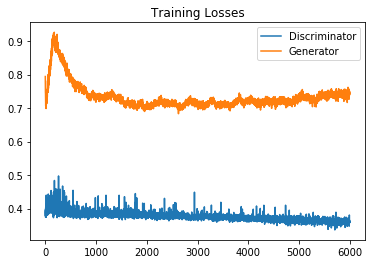

In [80]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

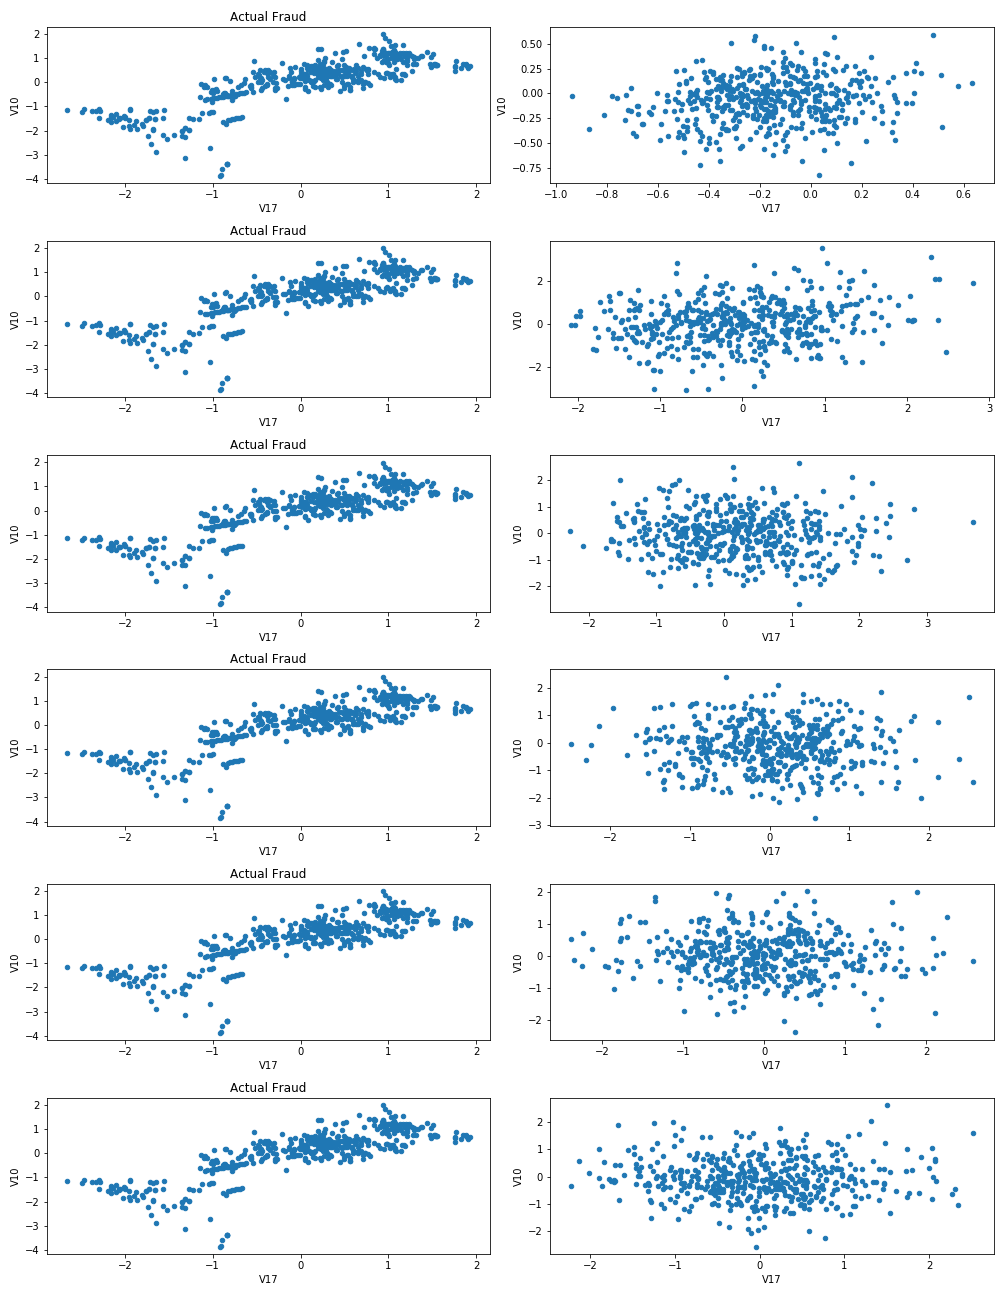

In [81]:
from IPython.display import Image
Image(filename='GANv1-ssl-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

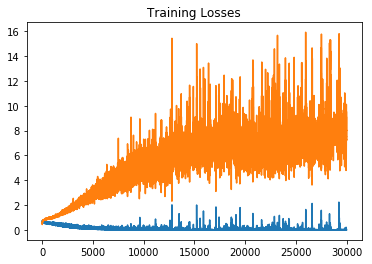

In [68]:
fig

In [50]:
test = pd.DataFrame([0,0,0,0,0,1,1,0], columns=['Class'])

In [58]:
indices = [i for i, x in enumerate(test.values) if x == 1]

In [59]:
indices

[5, 6]

In [85]:
gan

<__main__.GAN instance at 0x16543f1b8>

In [86]:
from keras.utils.vis_utils import plot_model
plot_model(gan.generator, to_file='ganv1-ssl-generator_plot.png', show_shapes=True, show_layer_names=True)


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.